# Hate Speech Model using Bi-LSTM
## Following notebook train and save weights of a Bi-LSTM on a hate speech dataset
[You can download the dataset used from here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/ "jigsaw-dataset") <br>

[Glove word embeddings used can be downloaded from here](https://nlp.stanford.edu/projects/glove/)


In [2]:
from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPool1D,Bidirectional,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import SpatialDropout1D,Dropout
from sklearn.metrics import roc_auc_score
from keras.models import model_from_json
from keras import regularizers

2024-08-15 15:54:24.421090: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 15:54:25.477611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 15:54:25.801593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 15:54:26.418879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 15:54:26.580752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 15:54:27.656045: I tensorflow/core/platform/cpu_feature_gu

In [3]:
# some configuration 
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 22000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [4]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../../Data/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # word embedding file is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [5]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("../../Data/toxic-comment/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values # there are no na values in the data though
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values
print ("Shape of data:",(train.shape))
print ("First 5 rows:",(train.head()))


Loading in comments...
Shape of data: (159571, 8)
First 5 rows:                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sentences length:", s[len(s) // 2])


max sequence length: 1400
min sequence length: 0
median sentences length: 35


In [7]:
# get word -> integer mapping
word2idx = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(word2idx))


Found 210337 unique tokens.


In [7]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

print('Completed...')

Filling pre-trained embeddings...
Completed...


In [8]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Padding sequences to a fixed length
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,  # Fixed input length
    trainable=False  # Keep embeddings fixed
)

# Building the model
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(30, return_sequences=False)(x)  # Simplified LSTM with fixed output shape
x = Dense(30, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),  # Standard learning rate
    metrics=['accuracy']
)

# Training the model
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=1,
    validation_split=VALIDATION_SPLIT
)



/usr/local/python/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-08-15 15:55:00.179668: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102124800 exceeds 10% of free system memory.


998/998 ━━━━━━━━━━━━━━━━━━━━ 63s 61ms/step - accuracy: 0.5946 - loss: 0.1933 - val_accuracy: 0.9941 - val_loss: 0.0663


In [9]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
]
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted and saved to model.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpto2f9792/assets


INFO:tensorflow:Assets written to: /tmp/tmpto2f9792/assets


Saved artifact at '/tmp/tmpto2f9792'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140596275774032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596275779488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596275781424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596275775792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596275780896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596275786000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596275788464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140596275787232: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1723737384.592521   81767 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723737384.592564   81767 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-15 15:56:24.592875: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpto2f9792
2024-08-15 15:56:24.593552: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-15 15:56:24.593569: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpto2f9792
2024-08-15 15:56:24.598771: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-08-15 15:56:24.599716: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-15 15:56:24.633531: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpto2f9792
2024-08-15 15:56:24.644677: I tensorflow/cc/saved_model/loader.cc

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "functional_1/lstm_1/TensorArrayV2_1@__inference_function_13369"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_13412"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListReserve' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["TensorListReserve:", "functional_1/lstm_1/TensorArrayV2_1@__inference_function_13369"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_13412"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["TensorListStack:", "functional_1/lstm_1/TensorArrayV2Stack/TensorListStack@__inference_function_13369"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_13412"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListStack' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["TensorListStack:", "functional_1/lstm_1/TensorArrayV2Stack/TensorListStack@__inference_function_13369"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_13412"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(fused["TensorListSetItem:", "functional_1/lstm_1/while/TensorArrayV2Write/TensorListSetItem@functional_1_lstm_1_while_body_13272"] at callsite(callsite(fused["While:", "functional_1/lstm_1/while@__inference_function_13369"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_13412"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]))): 'tf.TensorListSetItem' op is neither a custom op nor a flex op
<unknown>:0: note: loc(callsite(callsite(fused["While:", "functional_1/lstm_1/while@__inference_function_13369"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_13412"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): called from
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(fused["TensorListSetItem:", "functional_1/lstm_1/while/TensorArrayV2Write/TensorListSetItem@functional_1_lstm_1_while_body_13272"] at callsite(callsite(fused["While:", "functional_1/lstm_1/while@__inference_function_13369"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_13412"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]))): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: TensorListReserve, TensorListSetItem, TensorListStack
Details:
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x30xf32>>>) : {device = ""}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x30xf32>>>, tensor<i32>, tensor<?x30xf32>) -> (tensor<!tf_type.variant<tensor<?x30xf32>>>) : {device = "", resize_if_index_out_of_bounds = false}
	tf.TensorListStack(tensor<!tf_type.variant<tensor<?x30xf32>>>, tensor<2xi32>) -> (tensor<1x?x30xf32>) : {device = "", num_elements = 1 : i64}



In [23]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


c:\Users\visha\anaconda3\envs\pyenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(30, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x) #use dropout and regularization
x = GlobalMaxPool1D()(x)
x = Dense(30, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
print('##############')
print('Model built...')
print(model.summary())

Building model...
##############
Model built...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 50)        │     1,100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 60)        │        19,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 60)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           186 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121,456 (4.28 MB)

 Trainable params: 21,456 (83.81 KB)

 Non-trainable params: 1,100,000 (4.20 MB)

None


In [25]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=3,
  validation_split=VALIDATION_SPLIT
)



Training model...
Epoch 1/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 395s 385ms/step - accuracy: 0.5034 - loss: 0.2006 - val_accuracy: 0.9941 - val_loss: 0.0629
Epoch 2/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 318s 319ms/step - accuracy: 0.9302 - loss: 0.0720 - val_accuracy: 0.9941 - val_loss: 0.0591
Epoch 3/3
998/998 ━━━━━━━━━━━━━━━━━━━━ 240s 240ms/step - accuracy: 0.9747 - loss: 0.0660 - val_accuracy: 0.9941 - val_loss: 0.0601


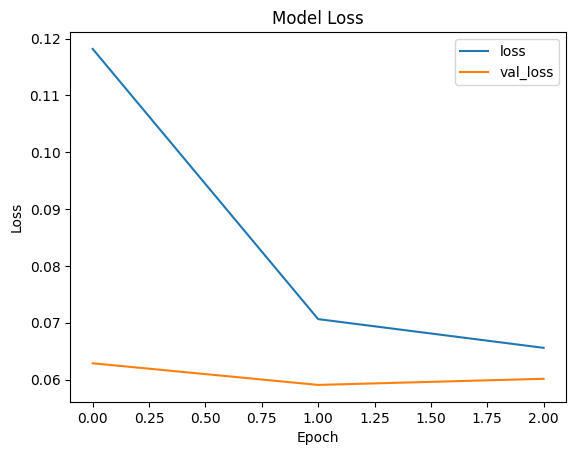

In [26]:
plt.figure()
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

0.6788008213043213
0.9941093325614929


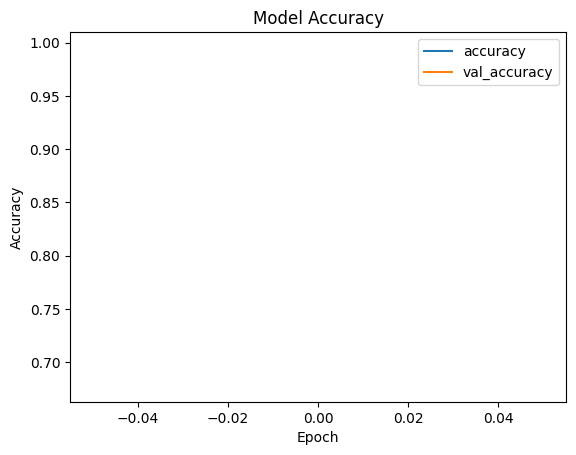

In [27]:
print(r.history['accuracy'][0])
print(r.history['val_accuracy'][0])
plt.figure()
plt.plot(r.history['accuracy'][0], label='accuracy')
plt.plot(r.history['val_accuracy'][0], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
    
print (aucs)
print(np.mean(aucs))

4987/4987 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step
[0.9495599251203917, 0.9800171860556415, 0.9684847266304906, 0.9430195062086656, 0.9650216302348411, 0.94710930760929]
0.9588687136432202


In [29]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
tok= Tokenizer()
# Save model architecture to JSON
model_json = model.to_json()
with open("../../output/lstm_hate_speech.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to H5
model.save_weights("../../output/lstm_hate_speech.weights.h5")



print("Saved model to disk")


Saved model to disk


In [10]:
import pickle


# Save tokenizer to a pickle file
with open('../../Output/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)